Last Updated 19/7/2023

This notebook is part of a broader investigation into how we can use ratings more effectively in the neural network. This includes: 
- incorporating Moody's ratings in some way 
- incorporating rating downgrades effectively, whether explicit or implicit (such as when a bond is prerefunded)

The following notebook is an investigation into the effectiveness of ratings in the neural network. **Jump to the section *Pricing Hypothetical Trades* for the analysis**.  

Initial analysis showed that the current model (tested using the model in deployment right now) is not as sensitive to exogenous ratings changes as expected (a downgrade from 'AAA' to Junk yielded a change in predictions ranging between 1-40bps). A look into the embeddings from the production model, however, showed that the embeddings did preserve the semantics of different ratings (ratings close together have similar vectors). 

My suspicion from this is that the model is not learning to use ratings appropriately downstream, since vector embeddings appear sensible but predictions do not. Before moving forward with using Moody's ratings, I looked into trying to help the network get more out of ratings.

**Intuition (if there is a more concrete way of testing this please let me know)**: The current network concatenates the multi-dimensional output from the LSTM sub-model and reference data sub-model and feeds that output through a series of dense layers to output a predicted yield spread. Because the outputs of each of the sub-models is multi-dimensional, we can think of them more as encodings of trade_history and reference data. My intuition is that this combination of encodings -> several dense layers downstream creates multiple interactions between the trade history and the reference data inputs and, since using the previous yield is very often the single best predictor of current yield, this muddles the model's ability to learn from reference data.

**TLDR:** The idea implemented here is simple: separate the trade history and reference sub-models more clearly. Each sub-model outputs a single scalar value which is combined in the final layer, which aligns the sub-models more closely with the idea of each of them predicting a yield spread and combining those predictions for a final predicted yield spread. Over 8 runs and in the data used in this notebook, MAE improves on average by ~0.4bps. Moreover, this new model is more sensitive to changes in ratings (and presumably, other reference data features, which I'll test some other time). This is ascertained in the same way that the original model was deemed to be insufficiently sensitive - we alter ratings for real trades and see how predictions change under the altered ratings, all else equal.

# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-08-10 08:00:06.180276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 08:00:06.282224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 08:00:06.284270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = '2023-01-01'
train_end = '2023-06-01'
test_start = '2023-06-01'
test_end = '2023-07-01'
#MODEL PARAMETERS 
VALIDATION_SPLIT = 0.1 #ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = 1000 #ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 75 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = 0.1 #ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
# target_variable = 'new_ys' 
target_variable = 'new_ys' 

In [3]:
print(train_start ,
train_end ,
test_start ,
test_end)

2023-01-01 2023-06-01 2023-06-01 2023-07-01


# Process Data

In [4]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [5]:
%time processed_data = load_data_from_pickle('processed_data_2023-07-24-14:53.pkl', 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 16.8 s, sys: 9.57 s, total: 26.4 s
Wall time: 57.8 s


In [6]:
processed_data.trade_history.apply(lambda x: x.shape).value_counts()

(10, 6)    4496783
Name: trade_history, dtype: int64

In [7]:
processed_data.target_attention_features.apply(lambda x: x.shape).value_counts()

(1, 3)    4496783
Name: target_attention_features, dtype: int64

In [8]:
processed_data.sort_values('trade_datetime', inplace=True)

## Checking data

In [9]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [10]:
processed_data[['yield','new_real_time_ficc_ycl']].describe()

,yield,new_real_time_ficc_ycl
count,4496783.000,4456073.000
mean,351.854,303.491
std,91.926,52.937
min,0.100,222.526
25%,290.000,265.675
50%,338.500,296.133
75%,407.400,324.551
max,9892.500,559.034


In [11]:
processed_data.reset_index(drop=True, inplace=True)

In [12]:
def process_data(data): 
    # data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    return data

In [13]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [14]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

CPU times: user 1min 54s, sys: 22 s, total: 2min 16s
Wall time: 5min 31s


In [15]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)
processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

CPU times: user 1.09 s, sys: 119 ms, total: 1.21 s
Wall time: 1.21 s


In [16]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

CPU times: user 44.6 s, sys: 16.5 s, total: 1min 1s
Wall time: 1min 7s


In [17]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [18]:
%%time 

processed_data = process_data(processed_data)

CPU times: user 49.6 s, sys: 20.8 s, total: 1min 10s
Wall time: 1min 19s


In [19]:
processed_data['moodys_rating'] = processed_data.moodys_long.fillna('NR')

In [20]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
if 'moodys_rating' not in CATEGORICAL_FEATURES:
    PREDICTORS.append('moodys_rating')
    CATEGORICAL_FEATURES.append('moodys_rating')
    
# if 'moodys_rating' in CATEGORICAL_FEATURES:
#     PREDICTORS.remove('moodys_rating')
#     CATEGORICAL_FEATURES.remove('moodys_rating')
        
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
max_ys_ttypes
min_ys_ttypes
max_qty_ttypes
min_ago_ttypes
D_min_ago_ttypes
P_min_ago_ttypes
S_min_ago_ttypes
moodys_rating


In [21]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 2.68 s, sys: 20.8 ms, total: 2.7 s
Wall time: 2.7 s


In [22]:
processed_data['trade_history_shortened'].apply(lambda x: x.shape).value_counts()

(5, 6)    4080954
Name: trade_history_shortened, dtype: int64

In [23]:
# %%time

# processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

In [24]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-06-30 00:00:00'), 4080954)

In [25]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [26]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-05-31 00:00:00
Test data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00


# Train NN

In [27]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        # if f in ['moodys_rating','rating']:
        #     continue
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)
    # rating_embeddings = []
    # ### ARCHITECTURE CHANGE FOR MOODYS
    # for f in ['moodys_rating','rating']:
    #     fin = layers.Input(shape=(1,), name = f)
    #     inputs.append(fin)
    #     embedded = layers.Flatten(name = f + "_flat")(layers.Embedding(input_dim = fmax[f]+1,
    #                                                                     output_dim = max(30,int(np.sqrt(fmax[f]))),
    #                                                                     input_length= 1,
    #                                                                     name = f + "_embed")(fin))
    #     rating_embeddings.append(embedded)
        
    # ratings_hidden = layers.Dense(100,activation='relu')(layers.concatenate(rating_embeddings, axis=-1))
    # ratings_hidden = layers.Dense(20,activation='relu', name='rating_combined')(ratings_hidden)
    # layer.append(ratings_hidden)

    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx



In [28]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [29]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError())

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model
    
    # return model



In [30]:
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

In [31]:
trade_history_col = 'trade_history_shortened'
yield_history_cols = []

In [32]:
# params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)

TRAINING DATA: N = 3024352, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
VALIDATION DATA: N = 336039, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-05-31 00:00:00
TEST DATA: N = 720563, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-30 00:00:00


2023-08-10 08:10:55.114577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 08:10:55.134822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 08:10:55.136859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 08:10:55.138514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [33]:
print(len(x_train))
for i in range(len(x_train)):
    print(x_train[i].shape)

15
(3024352, 5, 6)
(3024352, 1, 3)
(3024352, 48)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)
(3024352,)


In [ ]:
results = []
predictions = []
NUM_EPOCHS = 75

for i in range(4):
    tf.keras.utils.set_random_seed(10)
    start = time.time()
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = .75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/75


2023-08-10 08:11:39.407621: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 8633450496 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-10 08:11:50.770036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 556761 of 2268264
2023-08-10 08:12:00.770038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1111757 of 2268264
2023-08-10 08

3025/3025 [==============================] - ETA: 0s - loss: 14.5132

2023-08-10 08:14:31.747215: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 8633450496 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


3025/3025 [==============================] - 186s 41ms/step - loss: 14.5132 - val_loss: 10.6591
Epoch 2/75
3025/3025 [==============================] - 57s 19ms/step - loss: 10.5280 - val_loss: 10.0581
Epoch 3/75
3025/3025 [==============================] - 57s 19ms/step - loss: 10.1675 - val_loss: 9.8113
Epoch 4/75
3025/3025 [==============================] - 57s 19ms/step - loss: 9.9554 - val_loss: 9.6354
Epoch 5/75
3025/3025 [==============================] - 56s 19ms/step - loss: 9.8056 - val_loss: 9.5018
Epoch 6/75
3025/3025 [==============================] - 56s 18ms/step - loss: 9.6869 - val_loss: 9.3939
Epoch 7/75
3025/3025 [==============================] - 56s 19ms/step - loss: 9.5961 - val_loss: 9.3291
Epoch 8/75
3025/3025 [==============================] - 57s 19ms/step - loss: 9.5197 - val_loss: 9.2703
Epoch 9/75
3025/3025 [==============================] - 54s 18ms/step - loss: 9.4599 - val_loss: 9.2178
Epoch 10/75
3025/3025 [==============================] - 50s 16ms/ste

In [ ]:
# model.save('large_model_bottleneck1_dropout0.1_no_leakage')
# model.save('large_model_bottleneck1_dropout0.1_no_leakage')
# model.save('large_model_bottleneck1_moodys_noresidual_dropout0.1_no_leakage')
model.save('large_model_bottleneck1_moodys_dropout0.1_final')

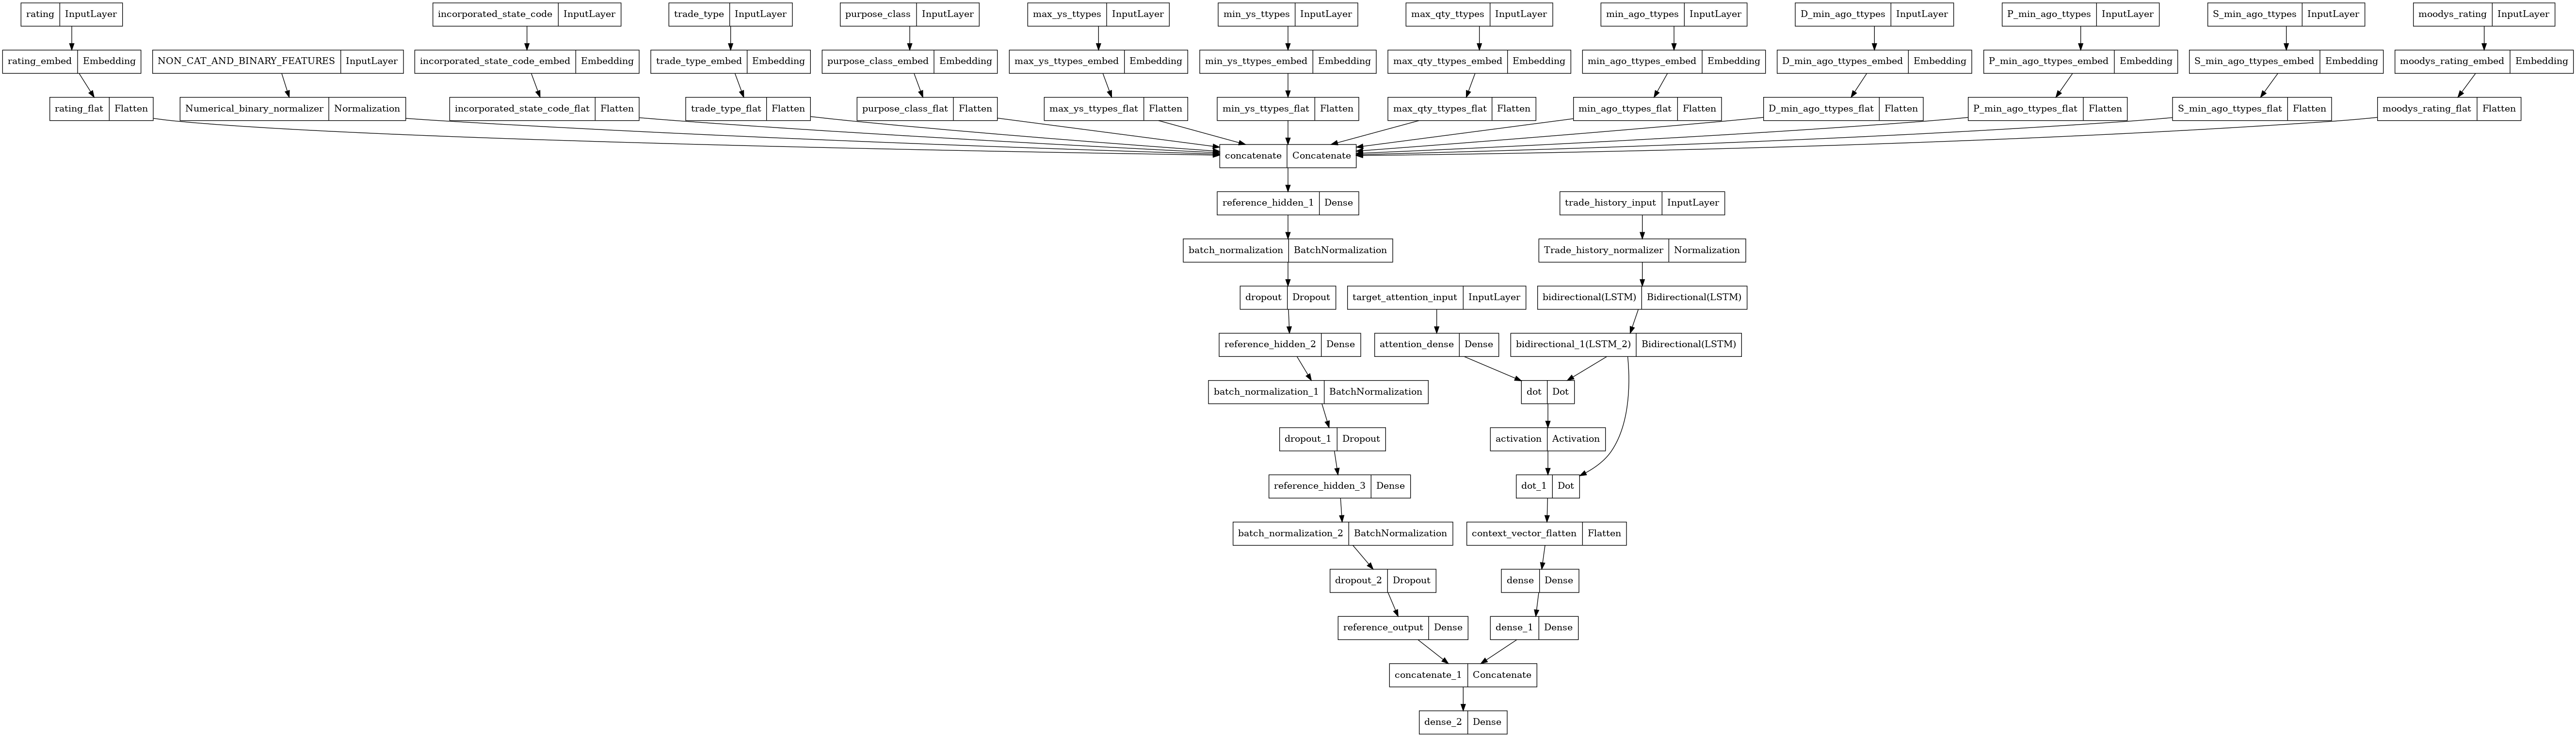

In [37]:
keras.utils.plot_model(model)

In [36]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS
#CORRECTED DENSE CONNECTIONS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.050
Trial 2: 8.071
Trial 3: 8.049
Trial 4: 8.050
Average MAE: 8.055


In [54]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#NO MOODYS
#CORRECTED DENSE CONNECTIONS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.044
Trial 2: 8.050
Trial 3: 8.073
Average MAE: 8.056


In [65]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS raw
#CORRECTED DENSE CONNECTIONS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.048
Trial 2: 8.062
Trial 3: 8.086
Trial 4: 8.069
Average MAE: 8.066


In [ ]:
#CURRENT TRIAL 

#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS raw
#CORRECTED DENSE CONNECTIONS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.051
Trial 2: 8.058
Trial 3: 8.029
Trial 4: 8.056
Average MAE: 8.048


In [50]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS SP CONCAT DENSE 1

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.206
Trial 2: 8.231
Trial 3: 8.213
Trial 4: 8.233
Average MAE: 8.221


In [79]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS SP CONCAT DENSE 1

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.260
Trial 2: 8.234
Trial 3: 8.244
Trial 4: 8.273
Trial 5: 8.259
Average MAE: 8.254


In [73]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS SP CONCAT DENSE 10

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.241
Trial 2: 8.241
Trial 3: 8.234
Trial 4: 8.227
Average MAE: 8.236


In [60]:
#75 EPOCHS 
#BOTTLENECK 1
#NO RESIDUAL 
#DROPOUT 0.1
#MOODYS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.112
Trial 2: 8.126
Trial 3: 8.130
Trial 4: 8.097
Trial 5: 8.116
Average MAE: 8.116


In [49]:
#75 EPOCHS 
#BOTTLENECK 1
#SP RESIDUAL 
#DROPOUT 0.1
#MOODYS

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.144
Trial 2: 8.142
Trial 3: 8.097
Trial 4: 8.143
Average MAE: 8.132


In [39]:
#75 EPOCHS 
#BOTTLENECK 1 
#NO RESIDUAL 
#DROPOUT 0.1 

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.219
Trial 2: 8.230
Trial 3: 8.227
Trial 4: 8.158
Trial 5: 8.227
Average MAE: 8.212


In [37]:
#75 EPOCHS 
#BOTTLENECK 1 
#RATINGS RESIDUAL 
#DROPOUT 0.1 

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.212
Trial 2: 8.159
Trial 3: 8.190
Trial 4: 8.221
Trial 5: 8.176
Average MAE: 8.192


In [97]:
#75 EPOCHS 
#BOTTLENECK 1 
#NO RESIDUAL 
#DROPOUT 0.1 

t = 0
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.186
Trial 2: 8.203
Trial 3: 8.193
Trial 4: 8.219
Trial 5: 8.199
Trial 6: 8.154
Average MAE: 8.192


In [46]:
#75 EPOCHS 
#BOTTLENECK 1 
#NO RESIDUAL 
#DROPOUT 0.01 

#SECOND RUN 26/7; 75 EPOCHS 0.01 DROPOUT; BOTTLENECK 1; NO RESIDUALS; FIXED TRADE HIST DERIVED FEATURES
for i, prediction in enumerate(predictions):
    print(f'Trial {i+1}: {mean_absolute_error(prediction, y_test):.3f}')
    t += mean_absolute_error(prediction, y_test)
print(f'Average MAE: {t/len(predictions):.3f}')

Trial 1: 8.362
Trial 2: 8.373
Trial 3: 8.403
Trial 4: 8.398
Trial 5: 8.339
Trial 6: 8.381
Average MAE: 8.376


# Pricing Hypothetical Trades

In [50]:
# synthetic_sampled_data = pd.read_pickle('synthetic_sampled_data_new.pkl')
# baseline_data = pd.read_pickle('synthetic_sampled_data_baseline.pkl')

In [51]:
def get_days(row, col):
    if pd.isna(row[col]) or pd.isna(row['settlement_date']):
        return 0
    else: 
        diff = diff_in_days_two_dates(row[col], row.settlement_date)
        if diff <= 0:
            return -1
        else:
            return diff
        
def sample_dataframe(df, N):
    '''Takes a dataframe from pd.groupby and samples N rows from it without replacement. The group name (in this case, the groupby index) is saved
    to a dictionary, groupby_id_dict'''
    
    group_name = df.name
    def index_to_dict(index_row):
        is_callable = index_row[0]
        interval = str(index_row[1].left)+'-'+str(index_row[1].right)
        rating = index_row[2]
        return {'is_callable':is_callable, 'interval': interval, 'rating':rating}
    
    df = df.drop_duplicates(subset='cusip')
    
    if len(df) < N:
        N = len(df)
    
    np.random.seed(1)
    result = df.sample(N, replace=False) 
    group_id = next(COUNT)
    result['group'] = group_id
    groupby_id_dict[group_id] = index_to_dict(group_name)
    return result


def create_synthetic_samples(df, col, vals):
    '''For a given cusip, the first trade is sampled and hypothetical trades are appended with by varying the column defined in col with values in vals'''
    for cusip in df.cusip.unique():
        for val in vals:
            temp = df[df.cusip == cusip].iloc[0] 
            if val != temp[col]:
                temp[col] = val
                df = df.append(temp)
    return df

def make_summary(col):
    '''Calculates the Max-Min range by cusip'''
    summary_df = synthetic_sampled_data.groupby(['cusip'])\
    ['predictions']\
    .agg(['std', max_min_f])\
    .rename({'<lambda_0>':'Max-Min'}, axis=1)\
    
    summary_df = summary_df.join(synthetic_sampled_data.set_index('cusip')[col])
    
    summary_df = summary_df.groupby(col).mean()
    # summary_df.columns = pd.MultiIndex.from_tuples(summary_df.columns)
    
    display(summary_df)
    
    return summary_df

In [52]:
data = test_dataframe
# data['days_to_call'] = data[['settlement_date','next_call_date']].apply(lambda x: get_days(x, 'next_call_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity'] = data[['settlement_date','maturity_date']].apply(lambda x: get_days(x, 'maturity_date'), axis = 1)/NUM_OF_DAYS_IN_YEAR
data['maturity_bucket'] = pd.cut(data['maturity'], [0, 5, 10, 15, 20, 30, data.maturity.max()])

In [53]:
#We just look at 5 rating values for efficiency 
RATINGS = ['AAA',  'BBB', 'CCC', 'NR']
groupby_cols = ['is_callable','maturity_bucket','rating']

sampled_data = data[data.rating.isin(RATINGS)].groupby(groupby_cols)
COUNT = iter(range(len(sampled_data.groups)))
groupby_id_dict = dict()

#Sample 20 random cusips from each maturity bucket, rating and callable combination 
sampled_data = sampled_data.apply(lambda x: sample_dataframe(x, 20)).reset_index(drop=True)

%time synthetic_sampled_data = create_synthetic_samples(sampled_data, 'rating', RATINGS)

CPU times: user 1min 26s, sys: 0 ns, total: 1min 26s
Wall time: 1min 28s


In [54]:
#Create input for model using original sampled data and sampled data augmented with hypothetical trades 
X_sample = create_input_new(sampled_data, trade_history_col, [])
X_sample_hypothetical_trades = create_input_new(synthetic_sampled_data, trade_history_col, [])

sampled_data_predictions  = model.predict(X_sample).flatten()
sampled_data_hypothetical_predictions  = model.predict(X_sample_hypothetical_trades).flatten()

sampled_data['predictions'] = sampled_data_predictions
synthetic_sampled_data['predictions'] = sampled_data_hypothetical_predictions

In [55]:
#to calculate max-min range within cusip
max_min_f = lambda x: x.max() - x.min()

synthetic_sampled_data['original_rating'] = synthetic_sampled_data['group'].apply(lambda x: groupby_id_dict[x]['rating'])

make_summary('is_callable');
make_summary('original_rating');
make_summary('maturity_bucket');

,std,Max-Min
is_callable,,
False,15.518,34.757
True,17.866,40.061


,std,Max-Min
original_rating,,
AAA,11.617,26.084
BBB,22.756,51.192
CCC,51.970,110.896
NR,17.371,38.714


,std,Max-Min
maturity_bucket,,
"(0.0, 5.0]",24.407,55.174
"(5.0, 10.0]",20.605,46.123
"(10.0, 15.0]",16.455,36.726
"(15.0, 20.0]",14.620,32.612
"(20.0, 30.0]",9.037,20.084
"(30.0, 46.211]",5.701,12.751


In [56]:
synthetic_sampled_data.to_pickle('synthetic_sampled_data_new_large_model.pkl')

In [57]:
baseline_data = pd.read_pickle('synthetic_sampled_data_large_model_baseline.pkl')

In [ ]:
A = synthetic_sampled_data.copy().drop_duplicates(subset=['cusip','rating'])
B = baseline_data.copy().drop_duplicates(subset=['cusip','rating'])
# print(len(A), len(B))

A['join'] = A['cusip']+'_'+A['rating']
B['join'] = B['cusip']+'_'+B['rating']

comp = pd.merge(A, 
             B[[ 'predictions', 'join']].rename({'predictions':'baseline_model_predictions'}, axis=1),
             left_on='join',
             right_on='join').drop('join',axis=1)

comp['predictions'] = comp['predictions'] + comp['new_real_time_ficc_ycl']
comp['baseline_model_predictions'] = comp['baseline_model_predictions'] + comp['new_real_time_ficc_ycl']

comp['baseline_error'] = comp['yield'] - comp['baseline_model_predictions']
comp['error'] = comp['yield'] - comp['predictions']

In [65]:
comp[['baseline_error','error']].corr().iloc[0,1]

0.8553405121366559

In [66]:
#Visualize some of the predictions with smallest and largest errors 
temp_df = comp[comp.rating == comp.original_rating]
select_cols = ['cusip', 'original_rating', 'rating', 'yield', 'predictions','baseline_model_predictions','error', 'baseline_error']
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).head())
display(temp_df[select_cols].sort_values(by='baseline_error', key = abs).tail())
display(temp_df[select_cols].sort_values(by='error', key = abs).head())
display(temp_df[select_cols].sort_values(by='error', key = abs).tail())

,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
79,89546RLE2,AAA,AAA,315.000,316.056,314.989,-1.056,0.011
424,503892BF7,NR,NR,542.400,541.267,542.422,1.133,-0.022
22,25041PAJ1,BBB,BBB,335.000,338.773,335.028,-3.773,-0.028
432,650346BP3,AAA,AAA,445.800,447.654,445.875,-1.854,-0.075
17,092765JF4,AAA,AAA,315.700,322.466,315.850,-6.766,-0.150


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
355,64542PDS1,NR,NR,1253.600,1182.032,1114.918,71.568,138.682
512,261333FB9,CCC,CCC,660.000,831.996,850.065,-171.996,-190.065
349,64542PDV4,NR,NR,1187.600,992.457,962.111,195.143,225.489
185,047375RB8,AAA,AAA,885.100,390.268,400.103,494.832,484.997
307,64542PDQ5,NR,NR,1869.700,1587.321,1363.597,282.379,506.103


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
122,101029VG8,AAA,AAA,297.600,297.673,296.498,-0.073,1.102
114,68608JWR8,NR,NR,310.200,310.295,302.794,-0.095,7.406
240,130179FU3,NR,NR,290.000,289.766,288.544,0.234,1.456
77,245505XF4,AAA,AAA,282.600,282.857,284.853,-0.257,-2.253
484,399064HB3,AAA,AAA,415.200,415.457,414.428,-0.257,0.772


,cusip,original_rating,rating,yield,predictions,baseline_model_predictions,error,baseline_error
360,592240UQ6,NR,NR,288.100,390.061,401.331,-101.961,-113.231
512,261333FB9,CCC,CCC,660.000,831.996,850.065,-171.996,-190.065
349,64542PDV4,NR,NR,1187.600,992.457,962.111,195.143,225.489
307,64542PDQ5,NR,NR,1869.700,1587.321,1363.597,282.379,506.103
185,047375RB8,AAA,AAA,885.100,390.268,400.103,494.832,484.997


Here we look at the average and standard deviation of the within-CUSIP Max-Min Range between the new model and the original model. The mean range and standard deviation of the ranges are larger for the new model's predictions, suggesting that it is more sensitive to ratings changes. Based on the histogram below, we see the same trend, though subtle - predicted yields stretch further out for the new model.

Average Max-Min Range across all CUSIPS:
 predictions                  37.615
baseline_model_predictions   25.457
dtype: float64

Std of Max-Min Range across all CUSIPS:
 predictions                  45.362
baseline_model_predictions   31.153
dtype: float64


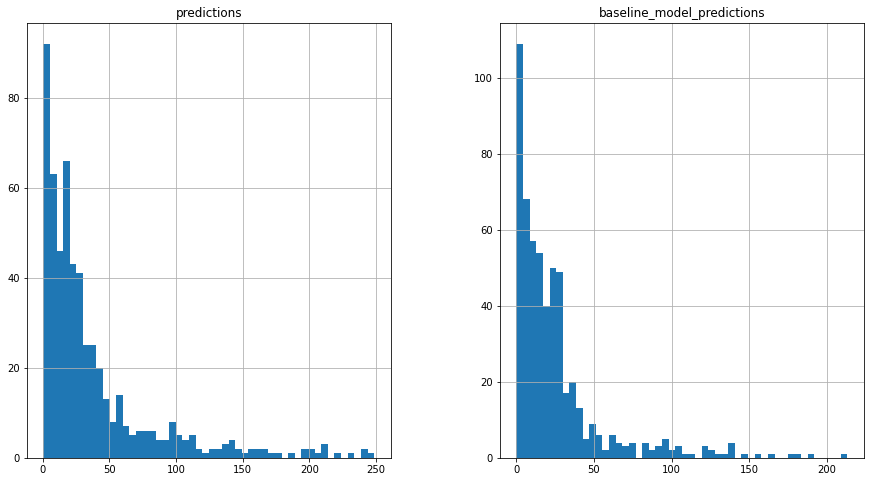

In [67]:
temp = comp.groupby('cusip')[['predictions','baseline_model_predictions']].apply(max_min_f)
print('Average Max-Min Range across all CUSIPS:\n', temp.mean())
print()
print('Std of Max-Min Range across all CUSIPS:\n', temp.std())
temp.hist(figsize=(15, 8), bins = 50);

Where the new_model has a larger range, that range averages 9.1bps. Where the baseline model has a larger range, that range averages 4.7bps. It is also twice as common for the new model to have a larger range (342 v 158)

In [68]:
len(temp[temp.predictions>temp.baseline_model_predictions]), len(temp[temp.predictions<temp.baseline_model_predictions])

(388, 167)

In [69]:
temp[temp.predictions>temp.baseline_model_predictions].diff(axis=1).mean()

predictions                      NaN
baseline_model_predictions   -21.847
dtype: float64

In [70]:
temp[temp.predictions<temp.baseline_model_predictions].diff(axis=1).mean()

predictions                     NaN
baseline_model_predictions   10.353
dtype: float64

Here we look at the average Max-Min range based on original rating and maturity. Predictions are more sensitive for bonds with lower ratings and shorter maturities. Obviously the impact of features like ratings on predictions is non-linear in the network, but this trend likely tells us also that bonds with lower ratings systematically have other features in favor of higher yields. In any case, the predictions of the new model are more sensitive.

In [71]:
comp.groupby(['cusip','original_rating'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('original_rating')\
.mean()

,predictions,baseline_model_predictions
original_rating,,
AAA,26.084,17.672
BBB,51.192,32.326
CCC,110.896,127.228
NR,38.714,28.210


In [72]:
comp.groupby(['cusip','maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()\
.groupby('maturity_bucket')\
.mean()

,predictions,baseline_model_predictions
maturity_bucket,,
"(0.0, 5.0]",55.174,32.684
"(5.0, 10.0]",46.123,31.581
"(10.0, 15.0]",36.726,26.960
"(15.0, 20.0]",32.612,21.190
"(20.0, 30.0]",20.084,16.864
"(30.0, 46.211]",12.751,9.965


In [73]:
temp = comp.groupby(['cusip','original_rating', 'maturity_bucket'])\
[['predictions','baseline_model_predictions']].apply(max_min_f)\
.reset_index()

In [74]:
temp[temp.baseline_model_predictions>temp.predictions].sort_values('baseline_model_predictions', ascending=False).head(20)

,cusip,original_rating,maturity_bucket,predictions,baseline_model_predictions
499,90020MBM9,NR,"(5.0, 10.0]",97.631,212.931
283,592240TH8,NR,"(0.0, 5.0]",139.510,163.322
415,71885FEG8,BBB,"(0.0, 5.0]",103.966,156.053
279,58312PAZ8,BBB,"(10.0, 15.0]",124.374,139.178
500,90020MBP2,NR,"(5.0, 10.0]",86.942,132.501
135,261333FB9,CCC,"(20.0, 30.0]",110.896,127.228
179,413890DA9,BBB,"(0.0, 5.0]",75.705,122.668
123,246388TK8,BBB,"(10.0, 15.0]",61.372,106.541
542,953140T59,BBB,"(10.0, 15.0]",72.747,96.611
379,67756DDH6,NR,"(0.0, 5.0]",91.156,92.933


We also check the model for consistency - in general, there is little reason for yields to go down if a bond's rating is downgraded. In other words, the relationship between rating and yield should be monotonically increasing. The model is more consistent if this happens. The code below checks for the consistency of yields in hypothetical trades if the yields are increasing from AAA -> BBB -> CCC (we drop NR hypothetical trades). We also check for the more general case where yields are higher when rating is AAA compared to CCC. 

Again, we see that the new model is more consistent. In particular, it is twice more likely to have monotonically increasing yields as rating decreases.

In [77]:
def check_monotonic(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']].diff()
    return ~(df <= 0).any(axis=0)

def check_monotonic_start_end(df):
    df = df[df.rating!='NR'].sort_values(by='rating')[['predictions','baseline_model_predictions']]
    df = df.iloc[-1] - df.iloc[0]
    return df >= 0

is_monotonic = comp.groupby('cusip').apply(check_monotonic)
is_monotonic_start_end = comp.groupby('cusip').apply(check_monotonic_start_end)

display(is_monotonic.mean())
display(is_monotonic_start_end.mean())

predictions                  0.541
baseline_model_predictions   0.595
dtype: float64

predictions                  0.796
baseline_model_predictions   0.870
dtype: float64